# Feature Analysis

## Summary
In this notebook, we investigate the predictive importance of health indicators in a medical domain. We use statistical techniques (including cross correlation and chi2 tests) as well as classical machine learning (logistic regression) to conduct the feature analysis. The focus here is feature importance, not model refinement. For brevity in this example,  we favour dropping rows/columns over imputing but acknowledge this isn't necessarily the best strategy. 

### Exploratory analysis
There are 3840 entries, although we quickly identify that each patient is duplicated 5 times with different "Blood Chemistry~III" values. We group the data by patient ID, taking the average "Blood Chemistry III" values.
We take a count on missing values. As this is minimal, we drop rows with missing values.
We then produce a matrix of plots to observe each variable and quickly identify problematic features (eg many patients with skin thickness of zero)

### Feature importance
We take two different approaches to cleaning the data (eg dropping columns or rows) and then conduct our analysis on the features.
1. Produce a heatmap on the cross correlation of the features
2. Train a simple model (logistic regression) on the outcome of the patient and then investigate feature importance within the model. We plot the features in order of importance. In Trial 1, we also provide plots on the univariate importance of a feature on the target
3. We take a different statistical approach and conduct a chi2 test to observe which features most strongly correlate with the outcome and agree with our previous results 

### Findings
We see broad agreement that "Blood Chemistry~I" is a very important factor. Other important features include "BMI", "# of Pregnancies", and "Age".



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2

## Load and inspect data

In [2]:
# Load the dataset
df = pd.read_csv('data/good_doctor_data.csv')
df.head()

,Unique_ID,# Pregnancies,Blood Chemestry~I,Blood Chemisty~II,Blood Chemisty~III,Blood Pressure,Skin Thickness,BMI,Genetic Predisposition Factor,Age,Air Qual'ty Index,$tate,Outcome
0,5642197,1,87.0,77.0,0,68,34.0,37.6,0.401,24,1.0,GA,0
1,5642863,3,187.0,200.0,0,70,22.0,36.4,0.408,36,6.0,CT,1
2,5642175,7,83.0,71.0,0,78,26.0,29.3,0.767,36,9.0,OR,0
3,5642237,4,92.0,0.0,0,80,0.0,42.2,0.237,29,11.0,NY,0
4,5642209,1,89.0,25.0,0,24,19.0,27.8,0.559,21,33.0,CA,0


## Exploratory analysis

In [31]:
# summary statistics
df.describe()

,Unique_ID,# Pregnancies,Blood Chemestry~I,Blood Chemisty~II,Blood Chemisty~III,Blood Pressure,Skin Thickness,BMI,Genetic Predisposition Factor,Age,Air Qual'ty Index,Outcome
count,3.840000e+03,3840.000000,3815.000000,3830.000000,3840.000000,3840.000000,3835.000000,3840.000000,3840.000000,3840.000000,3810.000000,3840.000000
mean,5.642502e+06,3.845052,120.917431,79.819843,174.164583,69.105469,20.542373,31.992578,0.471876,33.513021,49.107612,0.348958
std,2.217312e+02,3.367822,32.021104,115.274861,100.894649,19.345721,15.953456,7.880052,0.331156,13.722678,29.164915,0.476703
min,5.642118e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000
25%,5.642310e+06,1.000000,99.000000,0.000000,86.000000,62.000000,0.000000,27.300000,0.243750,24.000000,24.000000,0.000000
50%,5.642502e+06,3.000000,117.000000,30.500000,175.000000,72.000000,23.000000,32.000000,0.372500,29.000000,49.000000,0.000000
75%,5.642693e+06,6.000000,141.000000,127.000000,259.000000,80.000000,32.000000,36.600000,0.626250,41.000000,73.000000,1.000000
max,5.642885e+06,17.000000,199.000000,846.000000,350.000000,122.000000,99.000000,67.100000,2.420000,230.000000,100.000000,1.000000


In [32]:
# print the shape of the dataset
print(f"Shape of the dataset: {df.shape}")
print()

# double check this matches the number of unique patient IDs
print(f"Number of unique patient IDs: {df['Unique_ID'].nunique()}")
print()

# how many rows are recognised as duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")
print()

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())
print()

# check data types
print("Data types of each column:")
print(df.dtypes)

Shape of the dataset: (3840, 13)

Number of unique patient IDs: 768

Number of duplicate rows: 19

Missing values in each column:
Unique_ID                         0
# Pregnancies                     0
Blood Chemestry~I                25
Blood Chemisty~II                10
Blood Chemisty~III                0
Blood Pressure                    0
Skin Thickness                    5
BMI                               0
Genetic Predisposition Factor     0
Age                               0
Air Qual'ty Index                30
$tate                             0
Outcome                           0
dtype: int64

Data types of each column:
Unique_ID                          int64
# Pregnancies                      int64
Blood Chemestry~I                float64
Blood Chemisty~II                float64
Blood Chemisty~III                 int64
Blood Pressure                     int64
Skin Thickness                   float64
BMI                              float64
Genetic Predisposition Factor    

In [62]:
# print the columns of the DataFrame
print("Columns in the DataFrame:")
print(df.columns.tolist())

Columns in the DataFrame:
['Unique_ID', '# Pregnancies', 'Blood Chemestry~I', 'Blood Chemisty~II', 'Blood Chemisty~III', 'Blood Pressure', 'Skin Thickness', 'BMI', 'Genetic Predisposition Factor', 'Age', "Air Qual'ty Index", '$tate', 'Outcome']


In [33]:
# investigate an example of multiple entries for a single patient
patient_id = df['Unique_ID'].iloc[0]
patient_data = df[df['Unique_ID'] == patient_id]
print(f"Data for patient with Unique_ID {patient_id}:")
print(patient_data)

Data for patient with Unique_ID 5642197:
      Unique_ID  # Pregnancies  Blood Chemestry~I  Blood Chemisty~II  \
0       5642197              1               87.0               77.0   
278     5642197              1               87.0               77.0   
1822    5642197              1               87.0               77.0   
2727    5642197              1               87.0               77.0   
2949    5642197              1               87.0               77.0   

      Blood Chemisty~III  Blood Pressure  Skin Thickness   BMI  \
0                      0              68            34.0  37.6   
278                   26              68            34.0  37.6   
1822                 165              68            34.0  37.6   
2727                 246              68            34.0  37.6   
2949                 267              68            34.0  37.6   

      Genetic Predisposition Factor  Age  Air Qual'ty Index $tate  Outcome  
0                             0.401   24            

In [34]:
# and another example - to check for consistency
patient_id = df['Unique_ID'].iloc[1]
patient_data = df[df['Unique_ID'] == patient_id]
print(f"Data for patient with Unique_ID {patient_id}:")
print(patient_data)

Data for patient with Unique_ID 5642863:
      Unique_ID  # Pregnancies  Blood Chemestry~I  Blood Chemisty~II  \
1       5642863              3              187.0              200.0   
130     5642863              3              187.0              200.0   
881     5642863              3              187.0              200.0   
1068    5642863              3              187.0              200.0   
2331    5642863              3              187.0              200.0   

      Blood Chemisty~III  Blood Pressure  Skin Thickness   BMI  \
1                      0              70            22.0  36.4   
130                   12              70            22.0  36.4   
881                   80              70            22.0  36.4   
1068                 100              70            22.0  36.4   
2331                 211              70            22.0  36.4   

      Genetic Predisposition Factor  Age  Air Qual'ty Index $tate  Outcome  
1                             0.408   36            

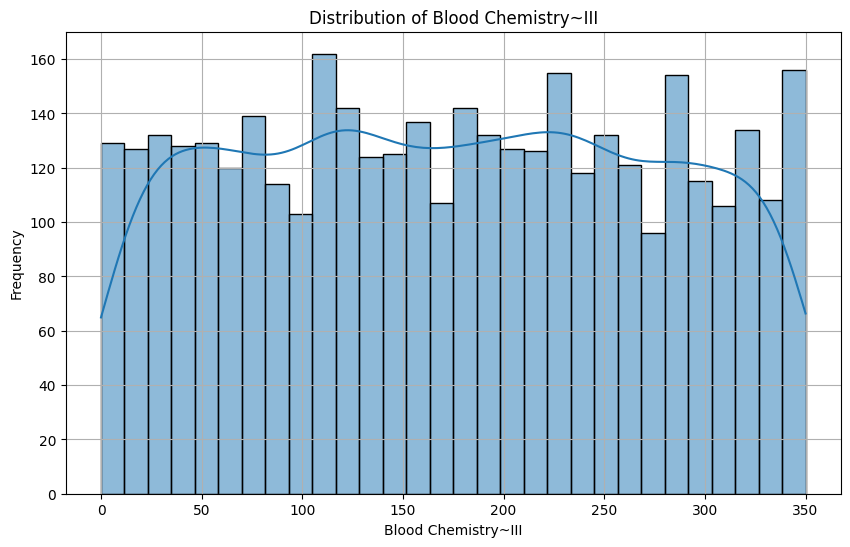

In [35]:
# visualise the distribution of Blood Chemistry~III
plt.figure(figsize=(10, 6))
sns.histplot(df['Blood Chemisty~III'], bins=30, kde=True)
plt.title('Distribution of Blood Chemistry~III')
plt.xlabel('Blood Chemistry~III')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [36]:
# merge entries for patients with multiple records, taking average blood chemistry III values
# we use mean for other columns too, but could use other aggregation methods if needed

df_merged = df.groupby('Unique_ID').agg({
    '# Pregnancies': 'mean', # this acts to double check consistency
    'Blood Chemestry~I': 'mean',
    'Blood Chemisty~II': 'mean',
    'Blood Chemisty~III': 'mean',
    'Blood Pressure': 'mean',
    'Skin Thickness': 'mean',
    'BMI': 'mean',
    'Genetic Predisposition Factor': 'mean',
    'Age': 'mean',
    'Air Qual\'ty Index': 'mean',
    '$tate': 'first',
    'Outcome': 'mean' # again, we check consistency - we should not see any decimal values
}).reset_index()

# print the shape of the merged dataset
print("Merged dataset shape:", df_merged.shape)
print()

# print the first few rows of the merged dataset#
print("Merged dataset head:")
print(df_merged.head())
print()

# check summary statistics of the merged dataset
print("Summary statistics of the merged dataset:")
print(df_merged.describe())
print()

Merged dataset shape: (768, 13)

Merged dataset head:
   Unique_ID  # Pregnancies  Blood Chemestry~I  Blood Chemisty~II  \
0    5642118            1.0                0.0               23.0   
1    5642119            1.0                0.0                0.0   
2    5642120            1.0                0.0                0.0   
3    5642121            5.0               44.0                0.0   
4    5642122            2.0               56.0               45.0   

   Blood Chemisty~III  Blood Pressure  Skin Thickness   BMI  \
0               127.6            74.0            20.0  27.7   
1               216.0            68.0            35.0  32.0   
2               133.6            48.0            20.0  24.7   
3               133.6            62.0             0.0  25.0   
4               179.2            56.0            28.0  24.2   

   Genetic Predisposition Factor   Age  Air Qual'ty Index $tate  Outcome  
0                          0.299  21.0               38.0    CA      0.0  
1 

In [37]:
# correct typos in column names
df_merged.columns = df_merged.columns.str.replace('Blood Chemestry~I', 'Blood Chemistry~I')
df_merged.columns = df_merged.columns.str.replace('Blood Chemisty~II', 'Blood Chemistry~II')
df_merged.columns = df_merged.columns.str.replace('Blood Chemisty~III', 'Blood Chemistry~III')
df_merged.columns = df_merged.columns.str.replace('Air Qual\'ty Index', 'Air Quality Index')
df_merged.columns = df_merged.columns.str.replace('$tate', 'State')

In [ ]:
# double check outcome column is still consistent
# ie it contains only 0s and 1s
print("Unique values in Outcome column after merging:")
print(df_merged['Outcome'].unique())
print()

# and number of pregnancies
# ie it contains only integers
print("Unique values in # Pregnancies:")
print(df_merged['# Pregnancies'].unique())

Unique values in Outcome column after merging:
[0. 1.]

Unique values in # Pregnancies:
[ 1.  5.  2.  9.  0.  3.  7.  8. 10.  4. 13.  6. 11. 12. 14. 15. 17.]


In [39]:
# check shape of the merged dataset
print(f"Shape of the merged dataset: {df_merged.shape}")
print()

# recheck duplicates in the merged dataset
print(f"Number of duplicate rows in the merged dataset: {df_merged.duplicated().sum()}")
print()

# check for missing values in the merged dataset
print("Missing values in each column of the merged dataset:")
print(df_merged.isnull().sum())
print()

Shape of the merged dataset: (768, 13)

Number of duplicate rows in the merged dataset: 0

Missing values in each column of the merged dataset:
Unique_ID                        0
# Pregnancies                    0
Blood Chemistry~I                5
Blood Chemistry~II               2
Blood Chemistry~III              0
Blood Pressure                   0
Skin Thickness                   1
BMI                              0
Genetic Predisposition Factor    0
Age                              0
Air Quality Index                6
State                            0
Outcome                          0
dtype: int64



In [ ]:
# drop any rows with missing values
df_merged.dropna(inplace=True)

# print the shape of the dataset after dropping missing values
print(f"Shape of the dataset after dropping missing values: {df_merged.shape}")
print()


Shape of the dataset after dropping missing values: (757, 13)



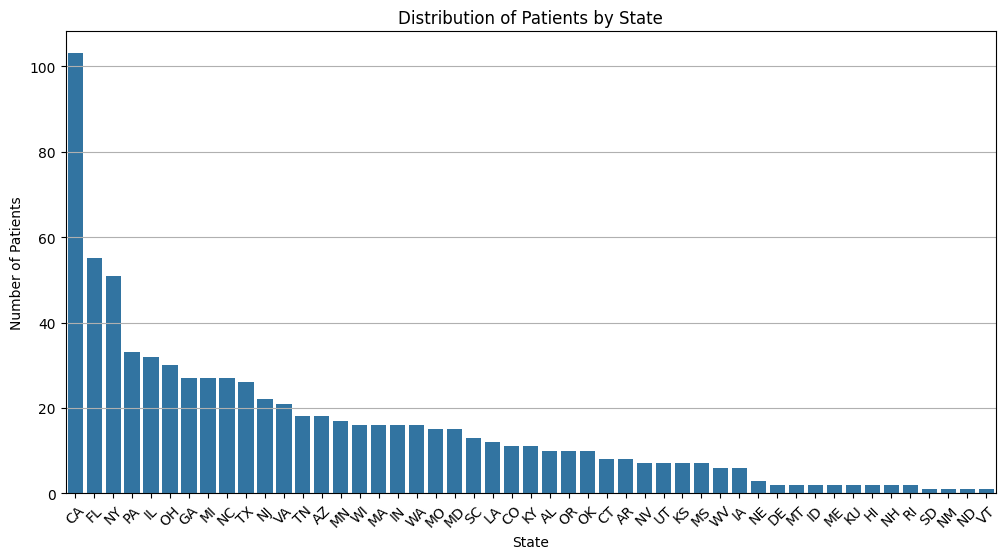

In [41]:
# check state distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df_merged, x='State', order=df_merged['State'].value_counts().index)
plt.title('Distribution of Patients by State')
plt.xlabel('State')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

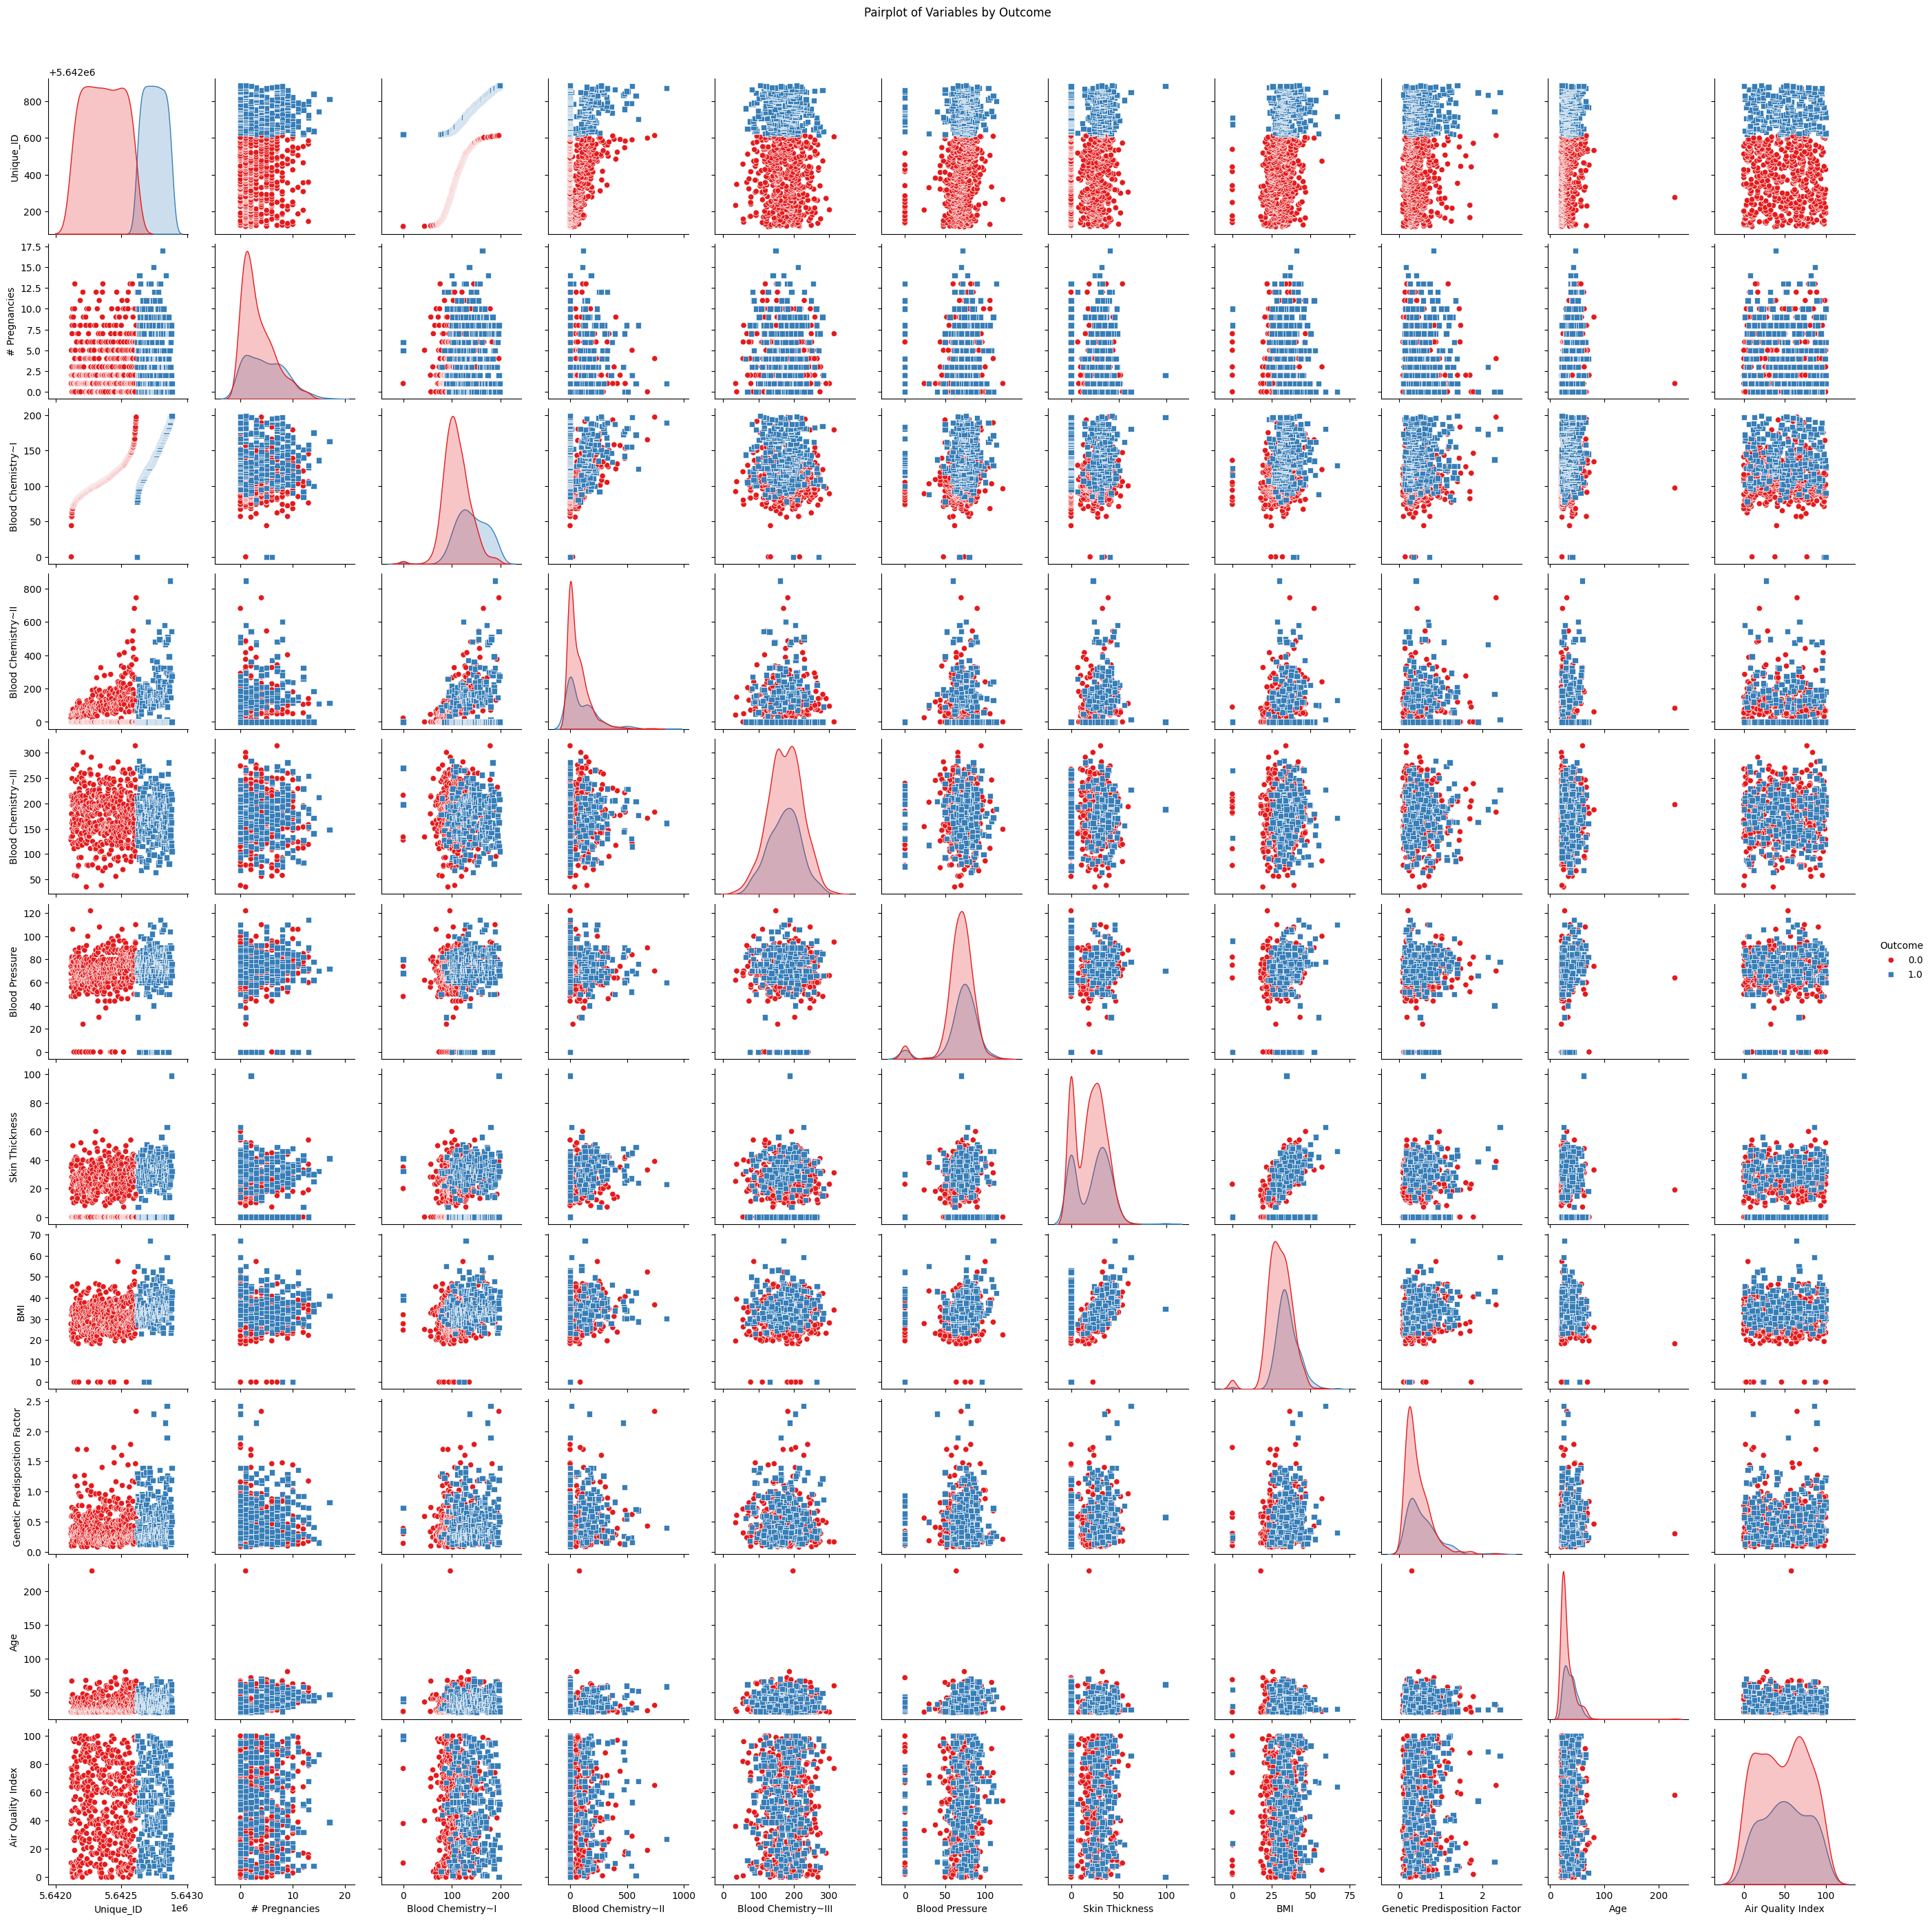

In [42]:
# check distribution across variables
sns.pairplot(df_merged, hue='Outcome', diag_kind='kde', markers=["o", "s"], palette="Set1")
plt.suptitle('Pairplot of Variables by Outcome', y=1.02)
plt.show()

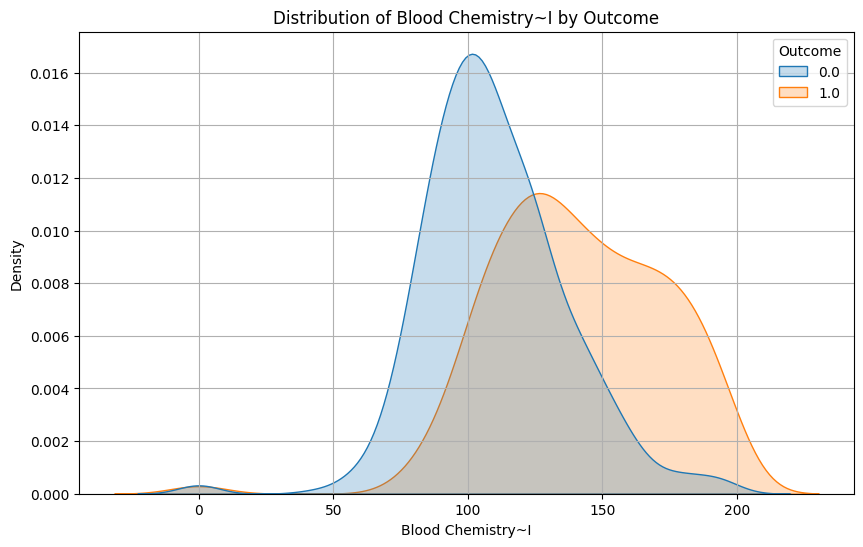

In [51]:
# additional plot for report
# plot the distribution of Blood Chemistry~I by Outcome 
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_merged, x='Blood Chemistry~I', hue='Outcome', common_norm=False, fill=True)
plt.title('Distribution of Blood Chemistry~I by Outcome')
plt.xlabel('Blood Chemistry~I')
plt.ylabel('Density')
plt.grid()
plt.show()


In [43]:
# inspect the outliers in various columns

# print total number of patients
print(f"Total number of patients in the merged dataset: {df_merged.shape[0]}")
print()

# in age ...
mean_age = df_merged['Age'].mean()
std_age = df_merged['Age'].std()
print(f"Mean Age: {mean_age}, Standard Deviation of Age: {std_age}")
outlier_threshold = mean_age + 3 * std_age
print(f"Outlier threshold for Age: {outlier_threshold}")
# identify outliers in Age
outliers_age = df_merged[df_merged['Age'] > outlier_threshold]  
print("Outliers in Age:")
print(outliers_age[['Unique_ID', 'Age']])
print()

# in skin thickness ...
mean_skin_thickness = df_merged['Skin Thickness'].mean()
std_skin_thickness = df_merged['Skin Thickness'].std()
print(f"Mean Skin Thickness: {mean_skin_thickness}, Standard Deviation of Skin Thickness: {std_skin_thickness}")
outlier_threshold_skin = mean_skin_thickness + 3 * std_skin_thickness
print(f"Outlier threshold for Skin Thickness: {outlier_threshold_skin}")
# identify outliers in Skin Thickness
outliers_skin = df_merged[df_merged['Skin Thickness'] > outlier_threshold_skin]
print("Outliers in Skin Thickness:")
print(outliers_skin[['Unique_ID', 'Skin Thickness']])
print()

# in BMI ...
mean_bmi = df_merged['BMI'].mean()
std_bmi = df_merged['BMI'].std()
print(f"Mean BMI: {mean_bmi}, Standard Deviation of BMI: {std_bmi}")
outlier_threshold_bmi = mean_bmi + 3 * std_bmi # we check for zeros later
print(f"Outlier threshold for BMI: {outlier_threshold_bmi}")
# identify outliers in BMI
outliers_bmi = df_merged[df_merged['BMI'] > outlier_threshold_bmi]
print("Outliers in BMI:")
print(outliers_bmi[['Unique_ID', 'BMI']])
print()

# in genetic predisposition factor ...
mean_genetic = df_merged['Genetic Predisposition Factor'].mean()
std_genetic = df_merged['Genetic Predisposition Factor'].std()
print(f"Mean Genetic Predisposition Factor: {mean_genetic}, Standard Deviation: {std_genetic}")
outlier_threshold_genetic = mean_genetic + 3 * std_genetic
print(f"Outlier threshold for Genetic Predisposition Factor: {outlier_threshold_genetic}")
# identify outliers in Genetic Predisposition Factor
outliers_genetic = df_merged[df_merged['Genetic Predisposition Factor'] > outlier_threshold_genetic]
print("Outliers in Genetic Predisposition Factor:")
print(outliers_genetic[['Unique_ID', 'Genetic Predisposition Factor']])
print()


Total number of patients in the merged dataset: 757

Mean Age: 33.557463672391016, Standard Deviation of Age: 13.768626168736157
Outlier threshold for Age: 74.86334217859948
Outliers in Age:
     Unique_ID    Age
159    5642277  230.0
414    5642532   81.0

Mean Skin Thickness: 20.6446499339498, Standard Deviation of Skin Thickness: 15.982853363212001
Outlier threshold for Skin Thickness: 68.59321002358581
Outliers in Skin Thickness:
     Unique_ID  Skin Thickness
764    5642882            99.0

Mean BMI: 32.01704095112286, Standard Deviation of BMI: 7.904175623722491
Outlier threshold for BMI: 55.729567822290335
Outliers in BMI:
     Unique_ID   BMI
356    5642474  57.3
600    5642718  67.1
729    5642847  59.4

Mean Genetic Predisposition Factor: 0.47202774108322326, Standard Deviation: 0.3322553689284724
Outlier threshold for Genetic Predisposition Factor: 1.4687938478686404
Outliers in Genetic Predisposition Factor:
     Unique_ID  Genetic Predisposition Factor
50     5642168      

In [44]:
# check BMI of zero values
print("Rows with BMI of zero:")
print(df_merged[df_merged['BMI'] == 0][['Unique_ID', 'BMI']])   


Rows with BMI of zero:
     Unique_ID  BMI
23     5642141  0.0
40     5642158  0.0
59     5642177  0.0
132    5642250  0.0
202    5642320  0.0
223    5642341  0.0
300    5642418  0.0
325    5642443  0.0
420    5642538  0.0
556    5642674  0.0
591    5642709  0.0


In [45]:
# check blood pressure of zero values
print("Number of rows with Blood Pressure of zero:")
print(df_merged['Blood Pressure'].value_counts().get(0, 0))


Number of rows with Blood Pressure of zero:
33


In [46]:
# check skin thickness of zero values
print("Number of rows with Skin Thickness of zero:")
print(df_merged['Skin Thickness'].value_counts().get(0, 0))

Number of rows with Skin Thickness of zero:
223


## Trial 1
In our first trial, we ...
- remove zero values for BMI & Blood Pressure
- remove 1 extreme value from age
- drop skin thickness and state

In [54]:
# copy df
df_t1 = df_merged.copy()
# print the shape of the copied dataset before drops  
print(f"Shape of the copied dataset before drops: {df_t1.shape}")

# drop rows with zero values in BMI and Blood Pressure
df_t1 = df_t1[(df_t1['BMI'] != 0) & (df_t1['Blood Pressure'] != 0)]
# drop row with age of 230
df_t1 = df_t1[(df_t1['Age'] != 230)]
# drop skin thickness and state column
df_t1.drop(columns=['Skin Thickness','State'], inplace=True)

# print the shape of the copied dataset after drops
print(f"Shape of the copied dataset after drops: {df_t1.shape}")

Shape of the copied dataset before drops: (757, 13)
Shape of the copied dataset after drops: (719, 11)


In [55]:
# scale the data
scaler = StandardScaler()

# store the columns to be scaled
scaled_cols = ['# Pregnancies', 'Blood Chemistry~I', 'Blood Chemistry~II',
        'Blood Chemistry~III', 'Blood Pressure', 'BMI', 
        'Genetic Predisposition Factor', 'Age', 'Air Quality Index']

# scale the selected columns
df_t1[scaled_cols] = scaler.fit_transform(
    df_t1[scaled_cols])

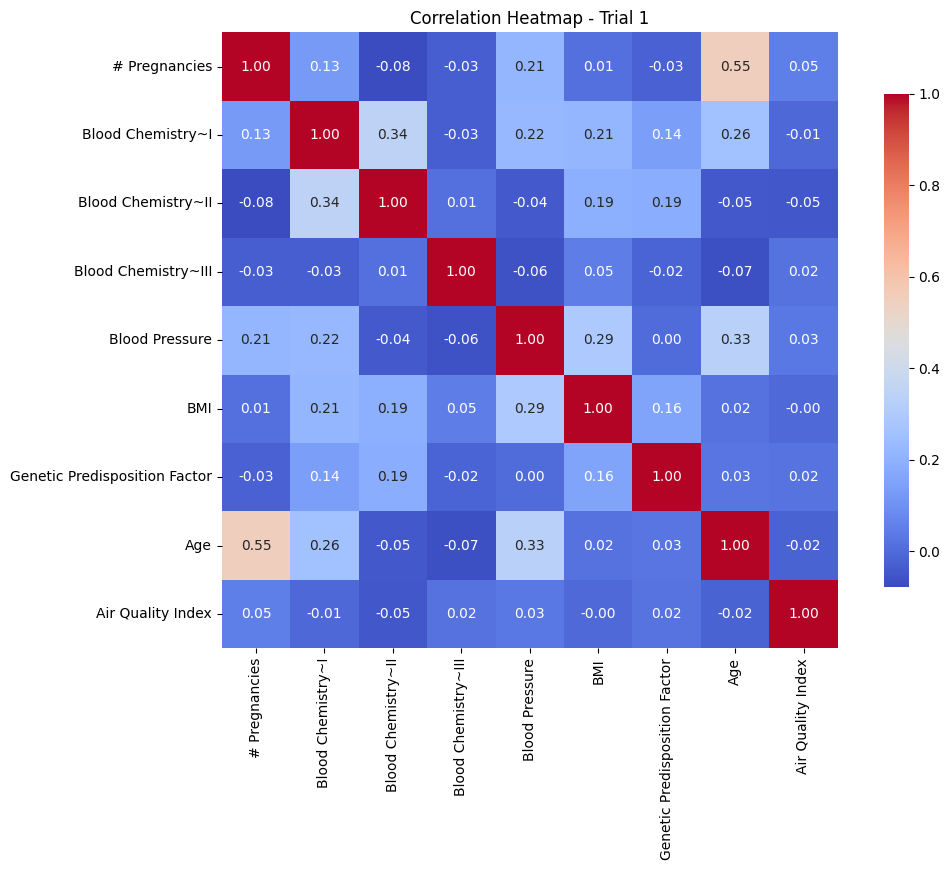

In [56]:
# visualize cross correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df_t1[scaled_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap - Trial 1')
plt.show()

/var/folders/f0/5ds76gxs38s75310kkpp75b00000gn/T/ipykernel_99128/4060355335.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


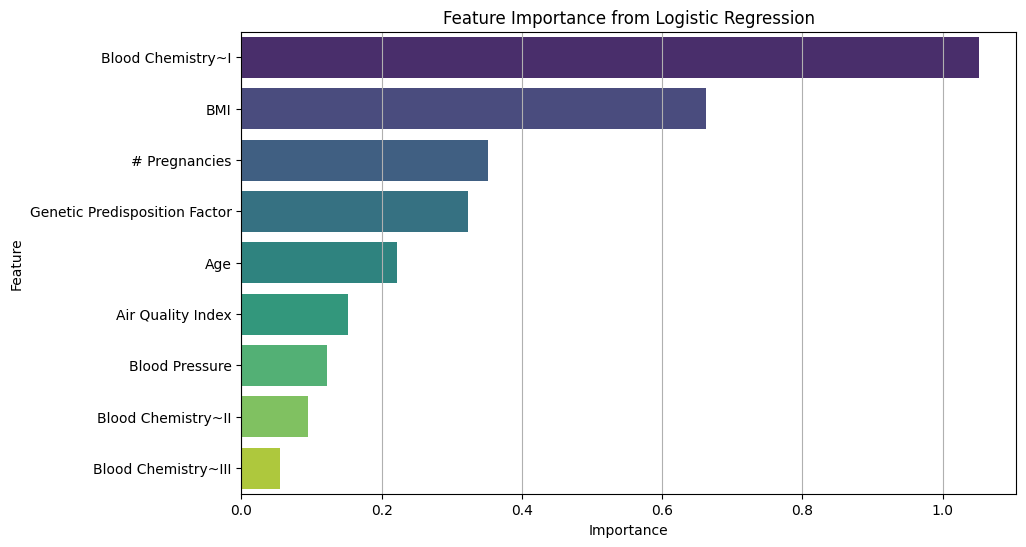

In [ ]:
# investigate feature importance using logistic regression
clf1 = LogisticRegression(max_iter=1000)

# fit the model
clf1.fit(df_t1[scaled_cols], df_t1['Outcome'])

# get feature importance
importance = np.abs(clf1.coef_[0])

# create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': scaled_cols,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance from Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x')
plt.show()


In [ ]:
# inspect features further 
# function for plotting univariate effect of a feature on the prediction probability
def plot_feature_effect(model, X, feature, scaler):
    """
    Plots the effect of a single feature on the prediction probability.
    
    Parameters:
    - model: Trained model
    - X: DataFrame with features
    - feature: Feature to visualize
    - scaler: Scaler used for the features
    """
    x_vals = np.linspace(X[feature].min(), X[feature].max(), 100)
    
    # Copy mean values of all features
    X_mean = pd.concat([X.mean().to_frame().T] * len(x_vals), ignore_index=True)
    X_mean[feature] = x_vals
    
    # Get prediction probabilities
    probs = model.predict_proba(X_mean)[:, 1]
    
    # unnormalize the feature for better visualization
    X_mean_inv = scaler.inverse_transform(X_mean)
    feature_idx = X.columns.get_loc(feature)
    x_vals_original = X_mean_inv[:, feature_idx]
    
    # plot
    plt.plot(x_vals_original, probs)
    plt.axhline(0.5, color='red', linestyle='--')  # Decision threshold
    plt.xlabel(feature)
    plt.ylabel('Probability of Positive Class')
    plt.title(f'Effect of {feature} on Prediction')
    plt.grid()
    plt.show()


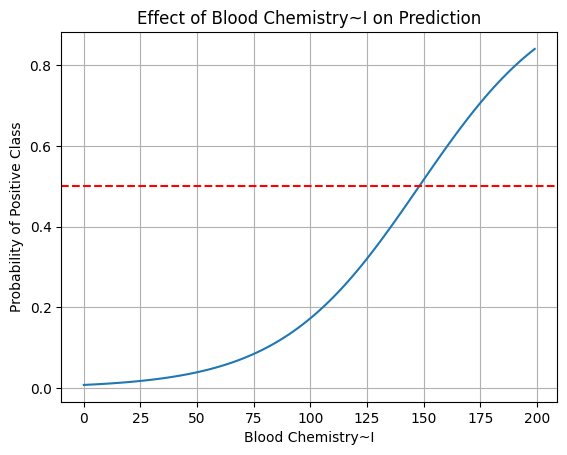

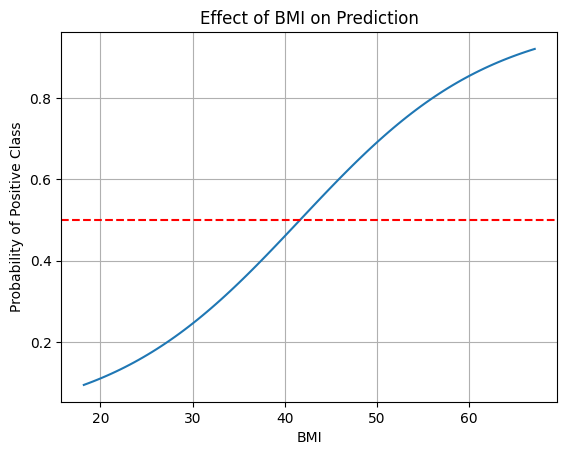

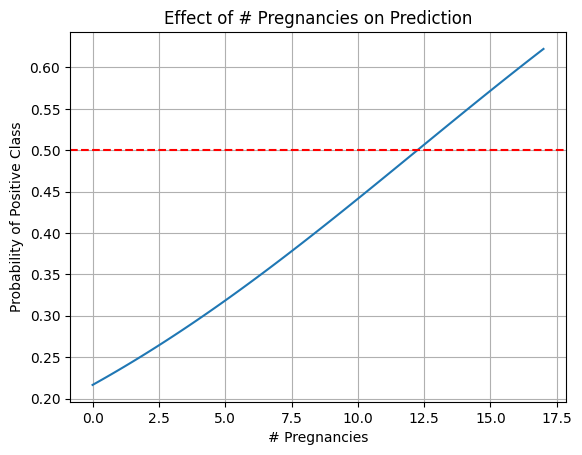

In [ ]:
# plot the effect of top 3 features
plot_feature_effect(clf1, df_t1[scaled_cols], 'Blood Chemistry~I', scaler)
print()
plot_feature_effect(clf1, df_t1[scaled_cols], 'BMI', scaler)
print()
plot_feature_effect(clf1, df_t1[scaled_cols], '# Pregnancies', scaler)
print()


/var/folders/f0/5ds76gxs38s75310kkpp75b00000gn/T/ipykernel_99128/808050655.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=feature_scores, palette='viridis')


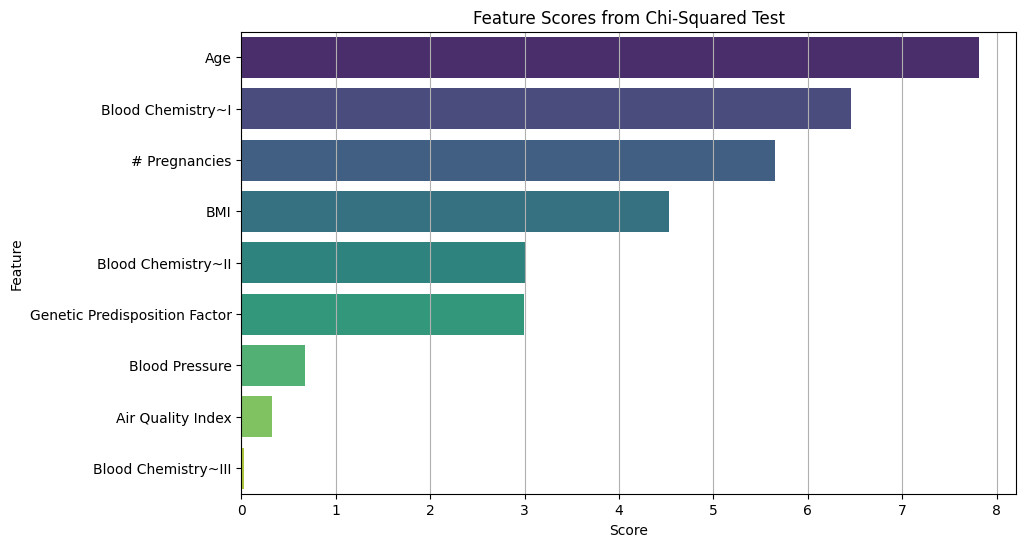

In [ ]:
# alternative feature importance/selection method
# use chi2 for feature selection

# we need to ensure that the features are non-negative for chi-squared test
# use min-max scaling to ensure all values are non-negative
scaler_minmax = MinMaxScaler()
# scale the selected columns to [0, 1] range
df_t1[scaled_cols] = scaler_minmax.fit_transform(df_t1[scaled_cols])
# ensure the outcome is binary (0 or 1)
df_t1['Outcome'] = df_t1['Outcome'].astype(int)

# select top 5 features based on chi-squared test
selector = SelectKBest(score_func=chi2, k=5)
# fit the selector to the data
X = df_t1[scaled_cols]
y = df_t1['Outcome']
selector.fit(X, y)

# get the scores and selected features
scores = selector.scores_
selected_features = X.columns[selector.get_support()]
# create a DataFrame for feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': scores
}).sort_values(by='Score', ascending=False)

# plot feature scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=feature_scores, palette='viridis')
plt.title('Feature Scores from Chi-Squared Test')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.grid(axis='x')
plt.show()

## Trial 2
In our second trial, we ...
- remove zero values for BMI, Skin Thickness, and Blood Pressure
- remove 1 extreme value from age and 1 extreme value for skin thickness
- drop state

In [57]:
# copy df
df_t2 = df_merged.copy()
# print the shape of the copied dataset before drops  
print(f"Shape of the copied dataset before drops: {df_t2.shape}")

# drop rows with zero values in BMI, Blood Pressure and Skin Thickness
df_t2 = df_t2[(df_t2['BMI'] != 0) & (df_t2['Blood Pressure'] != 0) & (df_t2['Skin Thickness'] != 0)]
# drop row with age of 230
df_t2 = df_t2[(df_t2['Age'] != 230)]
# drop row with skin thickness of 99
df_t2 = df_t2[(df_t2['Skin Thickness'] != 99)]
# drop state column
df_t2.drop(columns=['State'], inplace=True)

# print the shape of the copied dataset after drops
print(f"Shape of the copied dataset after drops: {df_t2.shape}")

Shape of the copied dataset before drops: (757, 13)
Shape of the copied dataset after drops: (528, 12)


In [58]:
# scale the data
scaler = StandardScaler()

# store the columns to be scaled
scaled_cols = ['# Pregnancies', 'Blood Chemistry~I', 'Blood Chemistry~II',
        'Blood Chemistry~III', 'Blood Pressure', 'BMI', 
        'Genetic Predisposition Factor', 'Age', 'Air Quality Index',
        'Skin Thickness']

# scale the selected columns
df_t2[scaled_cols] = scaler.fit_transform(
    df_t2[scaled_cols])

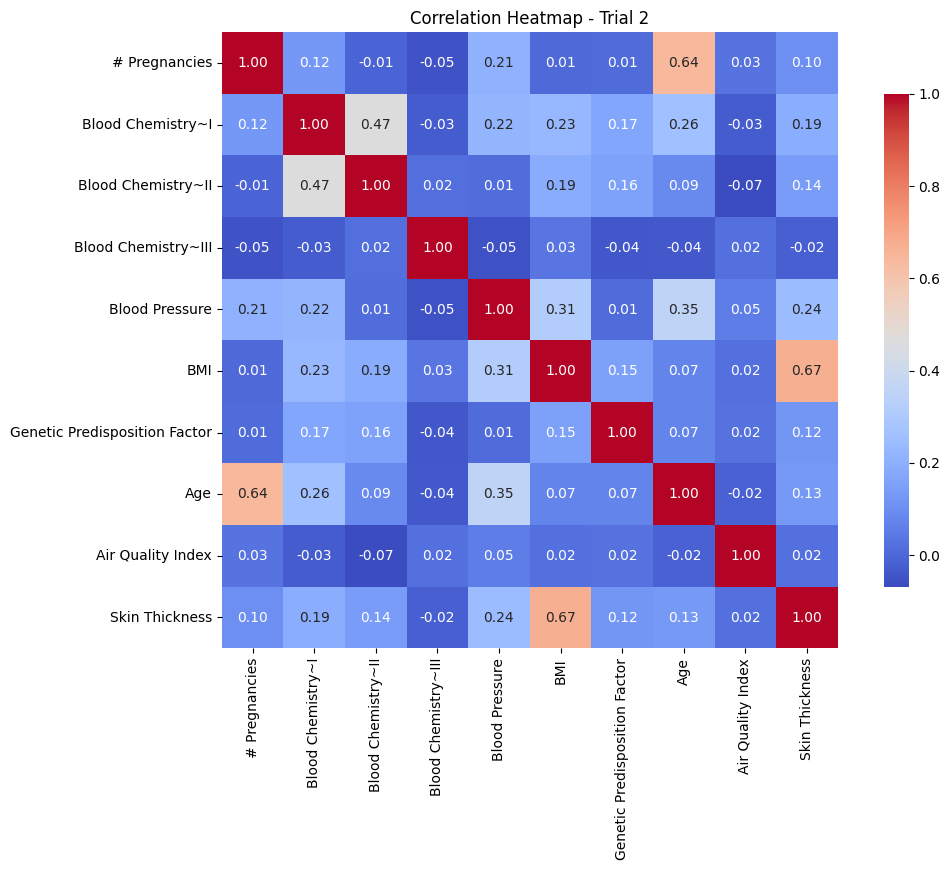

In [59]:
# heatmap to visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df_t2[scaled_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap - Trial 2')
plt.show()

/var/folders/f0/5ds76gxs38s75310kkpp75b00000gn/T/ipykernel_99128/2788984498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


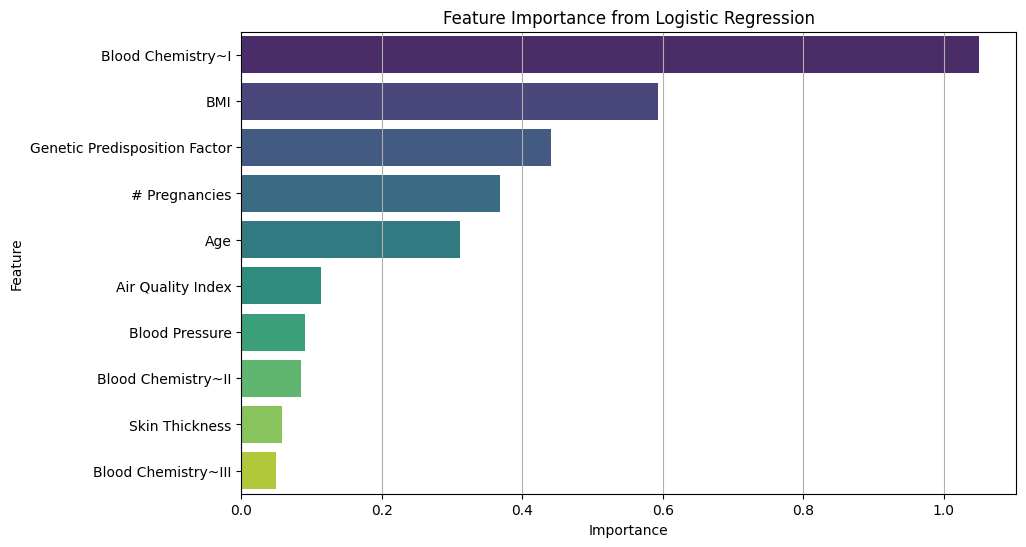

In [ ]:
# investigate feature importance using logistic regression
clf2 = LogisticRegression(max_iter=1000)

# fit the model
clf2.fit(df_t2[scaled_cols], df_t2['Outcome'])

# get feature importance
importance = np.abs(clf2.coef_[0])

# create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': scaled_cols,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance from Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x')
plt.show()

/var/folders/f0/5ds76gxs38s75310kkpp75b00000gn/T/ipykernel_99128/3608390257.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=feature_scores, palette='viridis')


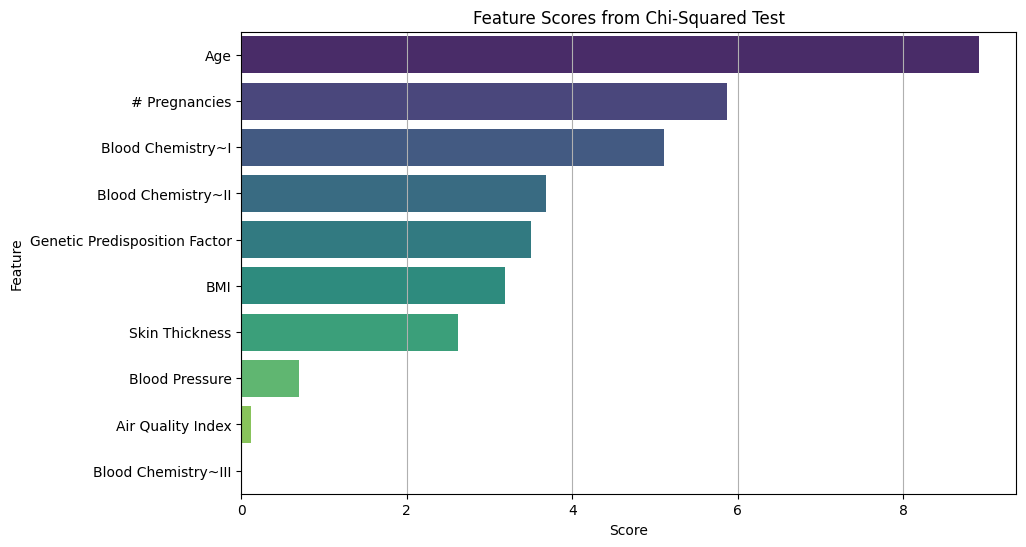

In [ ]:
# use chi2 for feature selection

# we need to ensure that the features are non-negative for chi-squared test
# use min-max scaling to ensure all values are non-negative
scaler_minmax = MinMaxScaler()
# scale the selected columns to [0, 1] range
df_t2[scaled_cols] = scaler_minmax.fit_transform(df_t2[scaled_cols])
# ensure the outcome is binary (0 or 1)
df_t2['Outcome'] = df_t2['Outcome'].astype(int)


# select top 5 features based on chi-squared test
selector = SelectKBest(score_func=chi2, k=5)
# fit the selector to the data
X = df_t2[scaled_cols]
y = df_t2['Outcome']
selector.fit(X, y)
# get the scores and selected features
scores = selector.scores_
selected_features = X.columns[selector.get_support()]
# create a DataFrame for feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': scores
}).sort_values(by='Score', ascending=False)

# plot feature scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=feature_scores, palette='viridis')
plt.title('Feature Scores from Chi-Squared Test')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.grid(axis='x')
plt.show()